In [1]:
%reload_ext autoreload
%autoreload 2


import sys
sys.path.append("..")

from common.utils import load_sql_to_df, plot_history, save_to_sql
from datasets import MoveAsTensorDataset
import common.board_representation as br

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from common.training import train_loop, test_model, Trainer
from models.move_evaluation import SentimateNet, SentimateNetSmaller, SentimateNetSkipLayer
from agents.agents import *

import random

import chess
import chess.engine
from stockfish import Stockfish
import pandas as pd
from tqdm import tqdm

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [4]:
def filter_func(row):
    board = chess.Board(row['position'])
    return board.is_legal(chess.Move.from_uci(row['move']))



tables = ["classified_moves_with_comments", "chessbase_moves_with_nags", "moves_from_books", "random_moves"]
classified_moves = [load_sql_to_df(f"SELECT position, move, sentiment FROM {table_name}", "../../chess.db") for table_name in tables]
classified_moves = pd.concat(classified_moves)
classified_moves = classified_moves[classified_moves.apply(filter_func, axis=1)]
classified_moves

,position,move,sentiment
0,r2r2k1/2q1bppp/3ppn2/pB3P2/P3P3/2B5/1P2Q1PP/3R...,e6e5,1
1,3q1bk1/3b4/pp5p/4p1p1/2P1N3/P1N2rP1/5P1P/1RBR2...,c3d5,1
2,r4r2/ppp3kp/2n3p1/3qp3/3p2P1/3P3P/PPPQNP2/4RRK...,f2f4,1
3,rnbqkb1r/ppp2p1p/5n2/3PN3/2B2ppP/8/PPPP2P1/RNB...,f8d6,1
4,2kr1b1r/p4pp1/2q1pn1p/1pp5/3P1P1P/2B3N1/PPP1Q1...,c5c4,1
...,...,...,...
891581,3q1k2/3bpnr1/2p5/3pP3/1PpP1RPP/2BR4/3K2B1/1N6 ...,c6c5,0
891582,3q1k2/3bpnr1/8/2ppP3/1PpP1RPP/2BR4/3K2B1/1N6 w...,g2h3,0
891583,3q1k2/3bpnr1/8/2ppP3/1PpP1RPP/2BR3B/3K4/1N6 b ...,d7e8,0
891584,3qbk2/4pnr1/8/2ppP3/1PpP1RPP/2BR3B/3K4/1N6 w -...,f4e4,0


In [8]:
classified_moves[classified_moves.sentiment == 0]

,position,move,sentiment
7,2kr3r/ppp1n1bp/3p4/3B2pq/3PPp2/2P2P1P/PP3K1B/R...,d1b3,0
23,r4rk1/pppq1ppp/1bn5/3n4/2BPP3/3QBP2/PP3PKP/R4R...,c4d5,0
27,8/2r5/3R4/8/8/2k5/1p1p4/1K6 b - - 1 74,c7a7,0
47,2b1r1k1/4rp2/1p3q1p/pP1p1PpP/PbpP2B1/4PP2/N1Q1...,e3e4,0
48,rn3rk1/pp2ppb1/6pp/q1p3N1/3PP1b1/2P1B2P/P2Q1PP...,g4h5,0
...,...,...,...
891581,3q1k2/3bpnr1/2p5/3pP3/1PpP1RPP/2BR4/3K2B1/1N6 ...,c6c5,0
891582,3q1k2/3bpnr1/8/2ppP3/1PpP1RPP/2BR4/3K2B1/1N6 w...,g2h3,0
891583,3q1k2/3bpnr1/8/2ppP3/1PpP1RPP/2BR3B/3K4/1N6 b ...,d7e8,0
891584,3qbk2/4pnr1/8/2ppP3/1PpP1RPP/2BR3B/3K4/1N6 w -...,f4e4,0


In [5]:
save_to_sql(classified_moves, db_filename="../../chess.db", table_name="sentimate_training_set", if_exists='replace')

In [9]:
train_df, test_df = train_test_split(classified_moves, test_size=0.005, random_state=0)
display(train_df)
display(test_df)

,position,move,sentiment
641064,6r1/1pp4k/3p2q1/p1bP3p/8/PP3QNn/1B3P1P/5R1K w ...,f3h5,0
577743,rn1q1br1/p1pkppp1/bp6/7p/2P3n1/5PP1/PPNPP2P/R1...,d7e8,0
617133,r4k2/5pp1/3p1b2/p2P4/5Pp1/1PPq3B/1P6/R1K3QR b ...,f6c3,1
100188,r4k1r/1p1n1bpp/1b1pp3/pQ3p2/2PP1n2/3RPNNP/6B1/...,b6c7,0
82685,2rq1rk1/pb2ppbp/1p1p1np1/8/1n2PP2/2NB1N1P/PPPQ...,b6b5,1
...,...,...,...
122338,8/2K5/k1N5/R7/8/8/2P5/4q3 b - - 9 9,e1a5,1
963512,4r1k1/5pp1/3r3p/Q7/1pB2q2/1P6/P1P5/1KR5 b - - ...,f4d2,1
87572,4rq1k/6pp/p3Br2/1pbP2B1/3pQ3/2p2P2/PP4PP/RN4K1...,b2c3,1
207400,1r3k1r/p4ppp/3b4/q2p4/3P4/1BPQP3/P3NPPP/4K2R w...,f2f3,1


,position,move,sentiment
444126,rn2k1nr/p1pp1pp1/bp6/2qPP3/1b3P2/2N3PB/PP5P/R1...,c1d2,1
409047,2k1r3/2p3pp/pp3b2/3R4/2p5/1P2B3/P1P2PPP/5K2 w ...,f1e2,1
705554,2b4r/3k3p/5p1P/p1pP4/1p1p2p1/2n1r1PR/PPKB1P2/N...,h1f3,0
773022,r2R4/1b1Q1k1p/p3p1p1/1pq2p2/8/8/PPP2PPP/5BK1 b...,f7f6,1
251653,6k1/1bp3b1/p6p/1p6/2n5/2PNK1N1/PP4q1/R1Q2R2 w ...,e3f4,1
...,...,...,...
243353,1nbqkbnr/r2pp1pp/1p6/p1p2p2/P2P4/1P5N/2PQPPPP/...,a1a2,0
188816,2r1k1r1/p1pp2B1/1n6/5pp1/PPP2P2/1N2PP2/B6P/R2K...,d7d6,0
71088,6n1/5k2/3p3r/5pp1/5pb1/1P3P2/P1P1BK2/2RR4 b - ...,f7e6,0
411287,3q1rk1/5ppp/1p1N4/r1nb1B1n/3p1B2/P7/1Q3PPP/3R1...,f4e5,1


In [10]:
train_dataset = MoveAsTensorDataset(train_df)
test_dataset = MoveAsTensorDataset(test_df)

In [3]:
model = SentimateNet()
model.to(device)
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.95)
scheduler = None

In [34]:
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4096)

In [35]:
# test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 36.31%, Avg loss: 0.698119


In [36]:
trainer = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [37]:
trainer.train(60, verbose=True)

Epoch 1/60
Train loss: 0.409503, accuracy: 83.58%
Val loss:   0.381527, accuracy: 85.20%
-----------------------------
Epoch 2/60
Train loss: 0.383454, accuracy: 84.98%
Val loss:   0.368610, accuracy: 85.78%
-----------------------------
Epoch 3/60
Train loss: 0.373607, accuracy: 85.45%
Val loss:   0.361034, accuracy: 86.15%
-----------------------------
Epoch 4/60
Train loss: 0.367790, accuracy: 85.71%
Val loss:   0.357081, accuracy: 86.24%
-----------------------------
Epoch 5/60
Train loss: 0.363908, accuracy: 85.85%
Val loss:   0.353712, accuracy: 86.38%
-----------------------------
Epoch 6/60
Train loss: 0.361522, accuracy: 85.93%
Val loss:   0.352143, accuracy: 86.42%
-----------------------------
Epoch 7/60
Train loss: 0.359599, accuracy: 85.99%
Val loss:   0.350424, accuracy: 86.47%
-----------------------------
Epoch 8/60
Train loss: 0.357862, accuracy: 86.04%
Val loss:   0.348656, accuracy: 86.52%
-----------------------------
Epoch 9/60
Train loss: 0.356774, accuracy: 86.06

In [46]:
trainer.train(60, verbose=True)

Epoch 61/120
Train loss: 0.344268, accuracy: 86.30%
Val loss:   0.341062, accuracy: 86.67%
-----------------------------
Epoch 62/120
Train loss: 0.344177, accuracy: 86.30%
Val loss:   0.341113, accuracy: 86.67%
-----------------------------
Epoch 63/120
Train loss: 0.344084, accuracy: 86.30%
Val loss:   0.340905, accuracy: 86.69%
-----------------------------
Epoch 64/120
Train loss: 0.344076, accuracy: 86.30%
Val loss:   0.340403, accuracy: 86.72%
-----------------------------
Epoch 65/120
Train loss: 0.343951, accuracy: 86.30%
Val loss:   0.340121, accuracy: 86.67%
-----------------------------
Epoch 66/120
Train loss: 0.343855, accuracy: 86.31%
Val loss:   0.340068, accuracy: 86.67%
-----------------------------
Epoch 67/120
Train loss: 0.344047, accuracy: 86.30%
Val loss:   0.339301, accuracy: 86.73%
-----------------------------
Epoch 68/120
Train loss: 0.343846, accuracy: 86.30%
Val loss:   0.339156, accuracy: 86.70%
-----------------------------
Epoch 69/120
Train loss: 0.34366

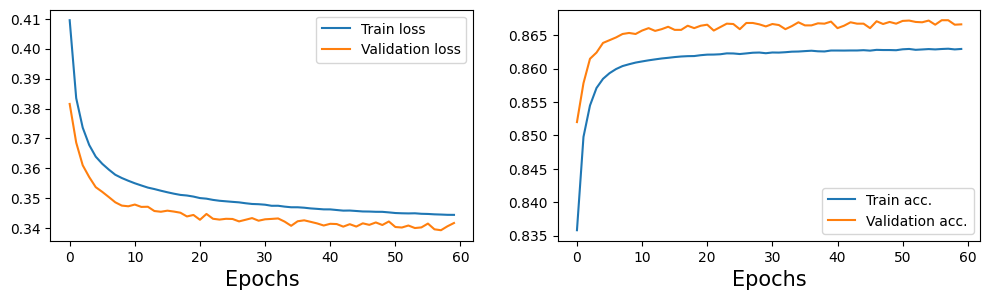

In [38]:
trainer.plot_history()

In [47]:
best_model = trainer.best_model()


Loading best params on validation set (epoch 67, accuracy: 86.73%)



In [53]:
best_model = trainer.best_model()


Loading best params on validation set (epoch 97, accuracy: 88.32%)



In [43]:
best_model = trainer.best_model()


Loading best params on validation set (epoch 69, accuracy: 88.32%)



In [78]:
model = SentimateNet(dropout=0)
model.to(device)
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.95)
trainer = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [80]:
trainer.train(20, verbose=True)

Epoch 1/20
Train loss: 0.378144, accuracy: 85.19%
Val loss:   0.353138, accuracy: 86.46%
-----------------------------
Epoch 2/20
Train loss: 0.347385, accuracy: 86.74%
Val loss:   0.335362, accuracy: 87.28%
-----------------------------
Epoch 3/20
Train loss: 0.333094, accuracy: 87.35%
Val loss:   0.322775, accuracy: 87.84%
-----------------------------
Epoch 4/20
Train loss: 0.323182, accuracy: 87.69%
Val loss:   0.316303, accuracy: 87.94%
-----------------------------
Epoch 5/20
Train loss: 0.315659, accuracy: 87.88%
Val loss:   0.312297, accuracy: 88.08%
-----------------------------
Epoch 6/20
Train loss: 0.309451, accuracy: 88.01%
Val loss:   0.308753, accuracy: 88.21%
-----------------------------
Epoch 7/20
Train loss: 0.304075, accuracy: 88.09%
Val loss:   0.308500, accuracy: 88.13%
-----------------------------
Epoch 8/20
Train loss: 0.298744, accuracy: 88.18%
Val loss:   0.307981, accuracy: 88.16%
-----------------------------
Epoch 9/20
Train loss: 0.293536, accuracy: 88.28

In [50]:
# torch.save(model.state_dict(), "../../models/Sentimate-6.01/last.model")
torch.save(best_model.state_dict(), "../../models/Sentimate-6.14/best.model")
# model.load_state_dict(torch.load("../../models/Sentimate_bad.model"))

In [4]:
model.load_state_dict(torch.load("../../models/Sentimate-6.05/best.model"))

<All keys matched successfully>

In [27]:
with torch.inference_mode():
    model.cpu()
    move_tensor = br.move_to_tensor(board.fen(), move).unsqueeze(0).float()
    xd = model(move_tensor)

print(xd)
# move_tensor.shape
# move_tensor.dtype

tensor([[1.6272]])


In [43]:
best_model.to(device)
test_model(test_loader, best_model)

Test Error: Accuracy: 88.32%, Avg loss: 0.300553


In [42]:
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [48]:
best_model.to(device)
model_agent = ModelAgent(best_model)
test_agent(model_agent, n_games=100)

100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


{'model_better': 86, 'random_better': 13, 'draw': 1}

In [39]:
model.to(device)
random_agent = RandomAgent()
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=1000)

100%|██████████| 500/500 [14:28<00:00,  1.74s/it]


{'model_better': 856, 'random_better': 122, 'draw': 22}

In [91]:
best_model.cuda()
best_model_agent = ModelAgent(best_model)
test_agent(best_model_agent, n_games=1000)

100%|██████████| 500/500 [14:38<00:00,  1.76s/it]


{'model_better': 882, 'random_better': 101, 'draw': 17}

In [49]:
best_model.cuda()
best_model_agent = ModelAgent(best_model)
test_agent(best_model_agent, n_games=1000)

100%|██████████| 500/500 [14:27<00:00,  1.73s/it]


{'model_better': 887, 'random_better': 92, 'draw': 21}

In [25]:
model = torch.load("../../models/Sentimate_bad.model")
random_agent = RandomAgent()
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=100)

{'model_better': 68, 'random_better': 30, 'draw': 2}

In [26]:
model = torch.load("../../models/Sentimate_good.model")
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [28]:
test_agent(model_agent, n_games=100)

{'model_better': 62, 'random_better': 34, 'draw': 4}

In [63]:
model = SentimateNetSmaller()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)
model

SentimateNetSmaller(
  (conv_layers): Sequential(
    (0): Conv2d(26, 13, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=200, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [64]:
trainer_2 = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [65]:
trainer_2.train(50, verbose=True)

Epoch 1/50
Train loss: 0.387549, accuracy: 84.75%
Val loss:   0.359533, accuracy: 86.16%
-----------------------------
Epoch 2/50
Train loss: 0.361657, accuracy: 86.13%
Val loss:   0.342334, accuracy: 87.04%
-----------------------------
Epoch 3/50
Train loss: 0.351033, accuracy: 86.66%
Val loss:   0.333993, accuracy: 87.41%
-----------------------------
Epoch 4/50
Train loss: 0.345741, accuracy: 86.90%
Val loss:   0.331138, accuracy: 87.56%
-----------------------------
Epoch 5/50
Train loss: 0.342788, accuracy: 87.03%
Val loss:   0.326798, accuracy: 87.75%
-----------------------------
Epoch 6/50
Train loss: 0.339953, accuracy: 87.15%
Val loss:   0.326296, accuracy: 87.73%
-----------------------------
Epoch 7/50
Train loss: 0.338341, accuracy: 87.21%
Val loss:   0.323304, accuracy: 87.86%
-----------------------------
Epoch 8/50
Train loss: 0.337047, accuracy: 87.26%
Val loss:   0.323195, accuracy: 87.85%
-----------------------------
Epoch 9/50
Train loss: 0.336219, accuracy: 87.28

In [66]:
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=1000)

100%|██████████| 500/500 [14:16<00:00,  1.71s/it]


{'model_better': 869, 'random_better': 112, 'draw': 19}

In [35]:
# model = torch.load("../../models/Sentimate_smaller.model")
# random_agent = RandomAgent()
model_agent = ModelAgent(model)
test_agent(model_agent, n_games=1000)

{'model_better': 845, 'random_better': 123, 'draw': 32}

In [77]:
model = SentimateNetSkipLayer()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)
model

SentimateNetSkipLayer(
  (conv1): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [80]:
trainer_3 = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [81]:
trainer_3.train(50, verbose=True)

Epoch 1/50
Train loss: 0.381766, accuracy: 85.06%
Val loss:   0.358309, accuracy: 86.05%
-----------------------------
Epoch 2/50
Train loss: 0.361648, accuracy: 86.06%
Val loss:   0.348813, accuracy: 86.62%
-----------------------------
Epoch 3/50
Train loss: 0.354222, accuracy: 86.40%
Val loss:   0.342424, accuracy: 87.00%
-----------------------------
Epoch 4/50
Train loss: 0.347701, accuracy: 86.71%
Val loss:   0.336761, accuracy: 87.29%
-----------------------------
Epoch 5/50
Train loss: 0.343007, accuracy: 86.93%
Val loss:   0.333503, accuracy: 87.34%
-----------------------------
Epoch 6/50
Train loss: 0.339115, accuracy: 87.09%
Val loss:   0.331148, accuracy: 87.49%
-----------------------------
Epoch 7/50
Train loss: 0.336321, accuracy: 87.20%
Val loss:   0.328128, accuracy: 87.51%
-----------------------------
Epoch 8/50
Train loss: 0.333621, accuracy: 87.30%
Val loss:   0.324091, accuracy: 87.72%
-----------------------------
Epoch 9/50
Train loss: 0.331480, accuracy: 87.38

In [82]:
trainer_3.optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)

trainer_3.train(10, verbose=True)

Epoch 51/60
Train loss: 0.306559, accuracy: 87.98%
Val loss:   0.308543, accuracy: 88.18%
-----------------------------
Epoch 52/60
Train loss: 0.306374, accuracy: 87.98%
Val loss:   0.307230, accuracy: 88.17%
-----------------------------
Epoch 53/60
Train loss: 0.305664, accuracy: 88.00%
Val loss:   0.307205, accuracy: 88.14%
-----------------------------
Epoch 54/60
Train loss: 0.305593, accuracy: 88.00%
Val loss:   0.309431, accuracy: 88.09%
-----------------------------
Epoch 55/60
Train loss: 0.305009, accuracy: 88.01%


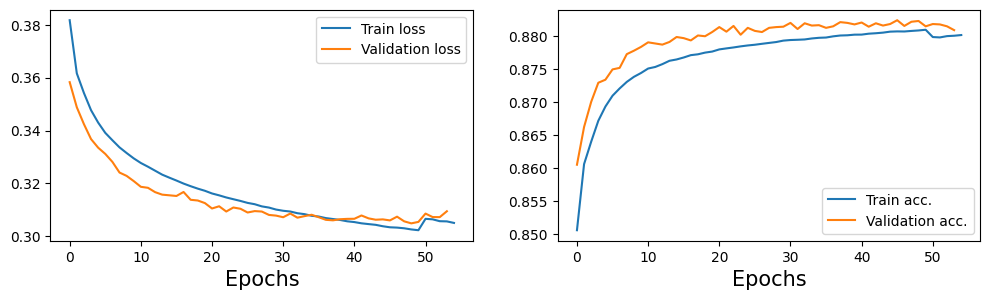

In [83]:
trainer_3.plot_history()

In [84]:
best_model_3 = trainer_3.best_model()
best_model_3_agent = ModelAgent(best_model_3)


Loading best params on validation set (epoch 46, accuracy: 88.24%)



In [86]:
test_agent(best_model_3_agent, n_games=100)

100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


{'model_better': 78, 'random_better': 20, 'draw': 2}

In [89]:
model_agent = ModelAgent(trainer.best_model())


Loading best params on validation set (epoch 6, accuracy: 88.21%)



In [90]:
test_agent(model_agent, n_games=100)

100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


{'model_better': 91, 'random_better': 7, 'draw': 2}

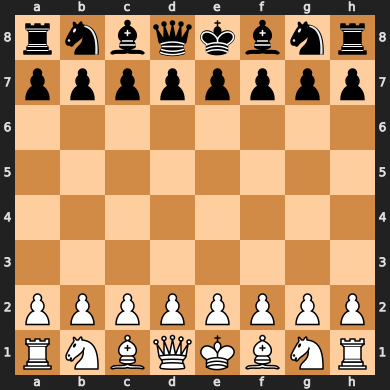

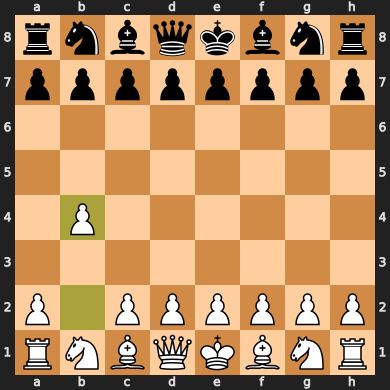

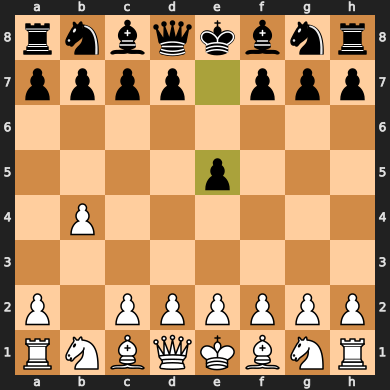

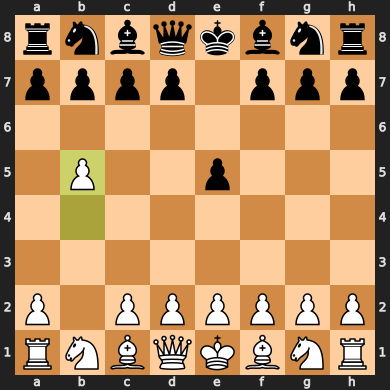

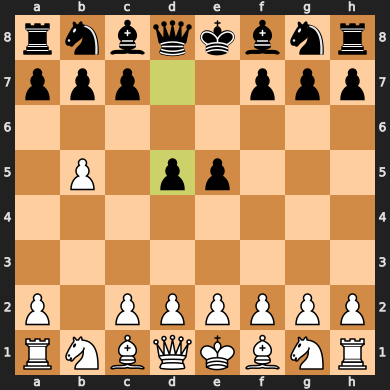

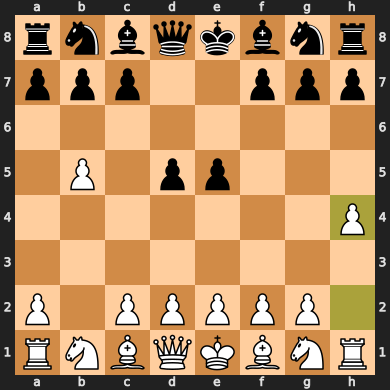

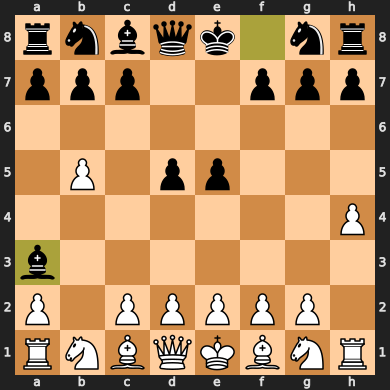

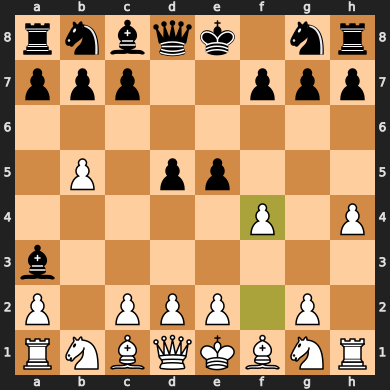

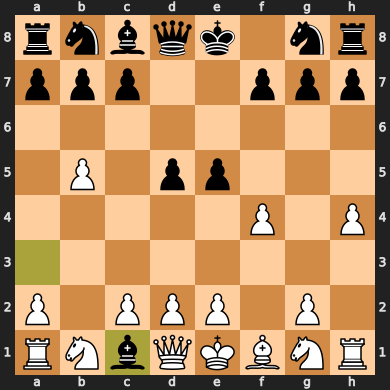

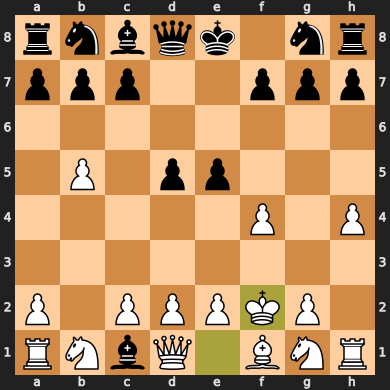

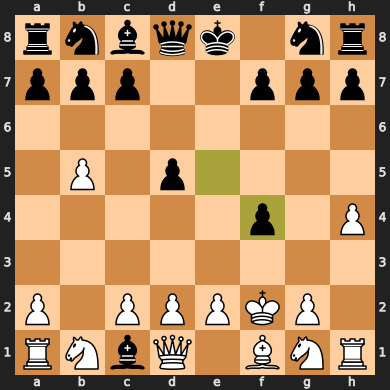

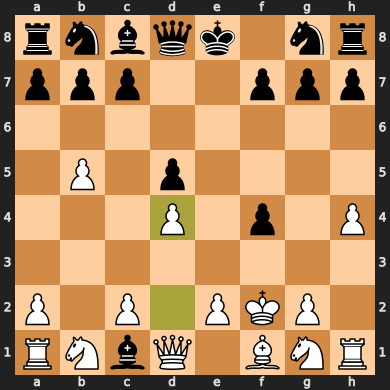

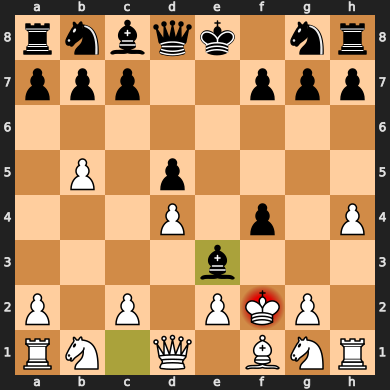

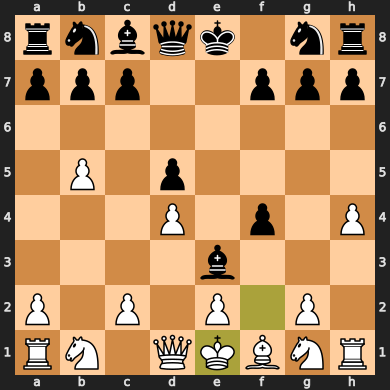

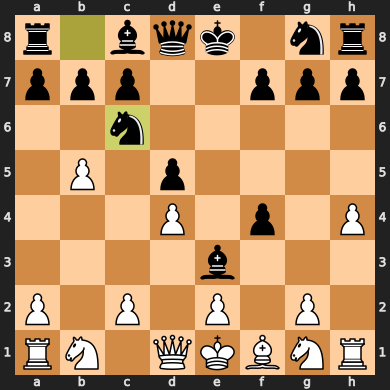

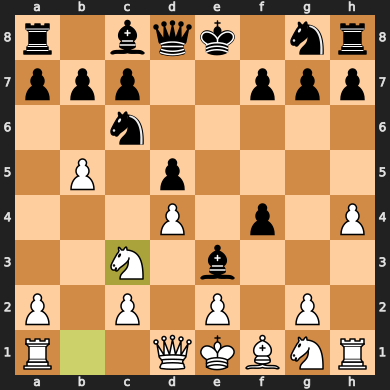

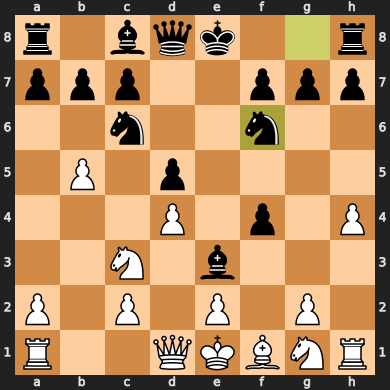

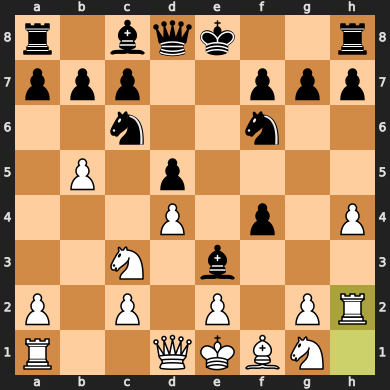

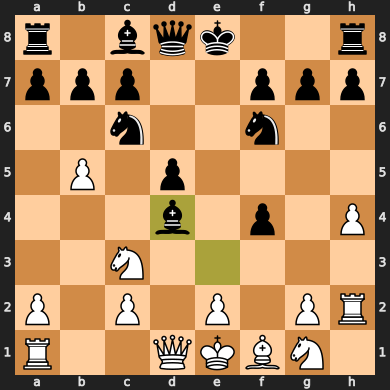

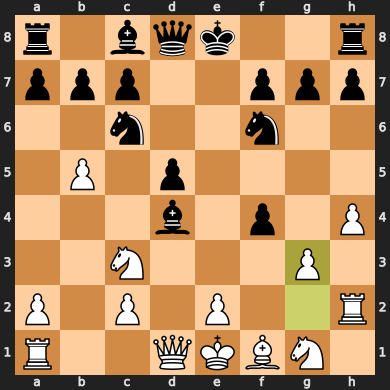

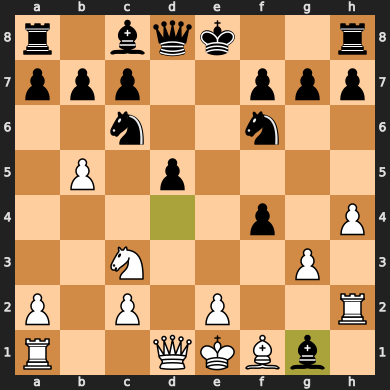

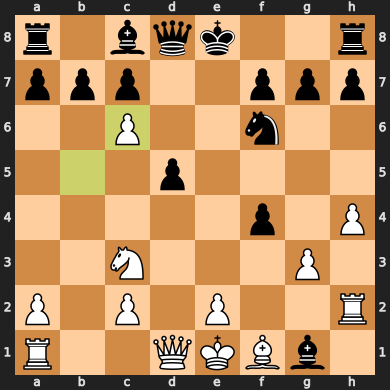

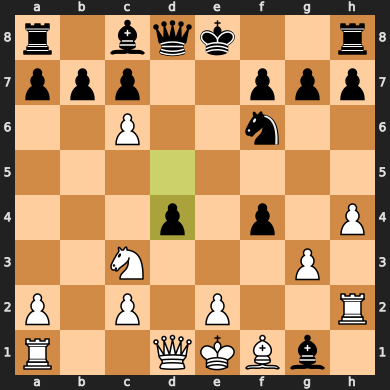

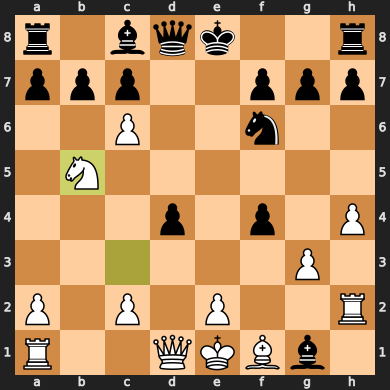

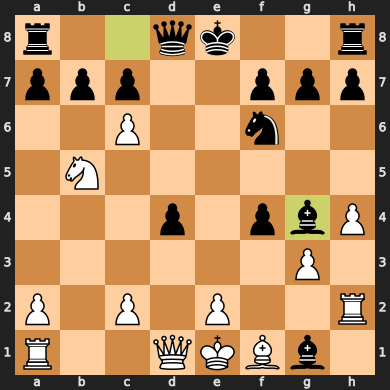

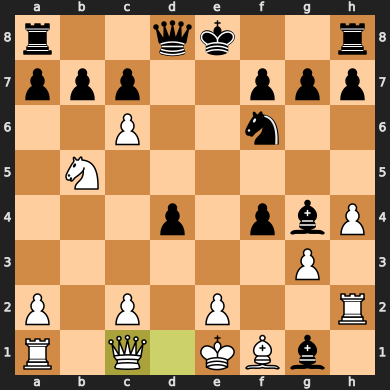

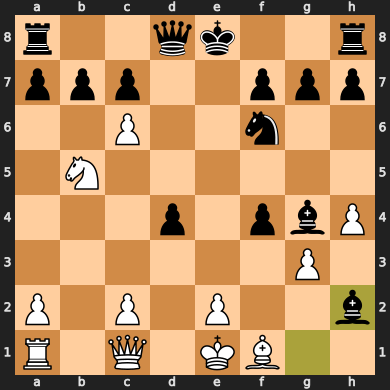

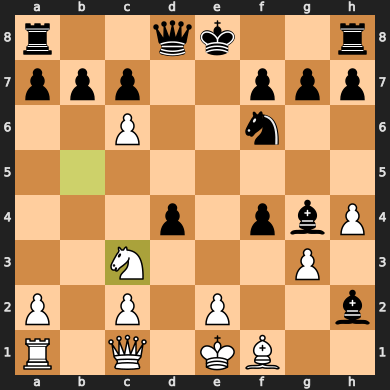

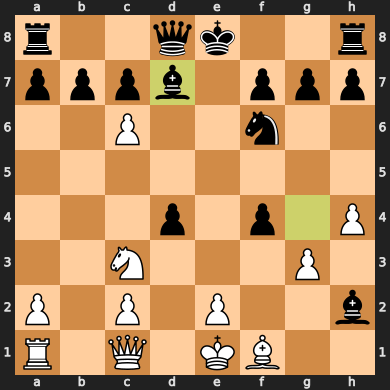

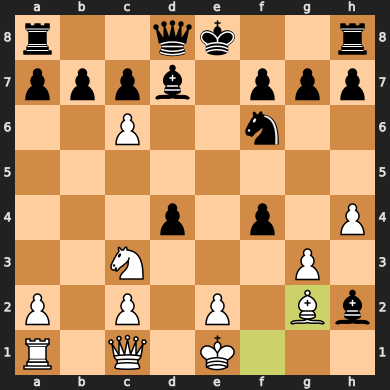

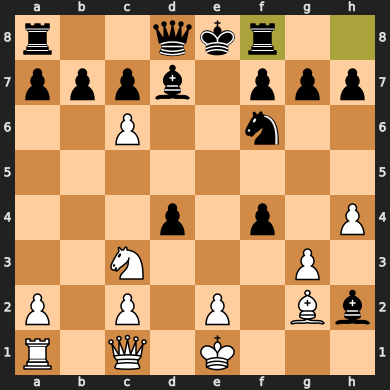

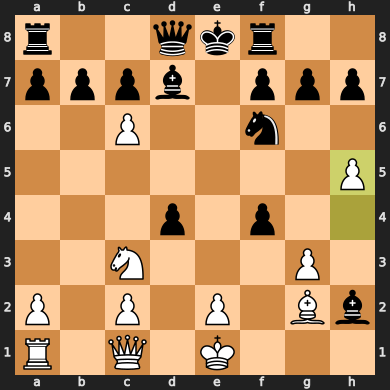

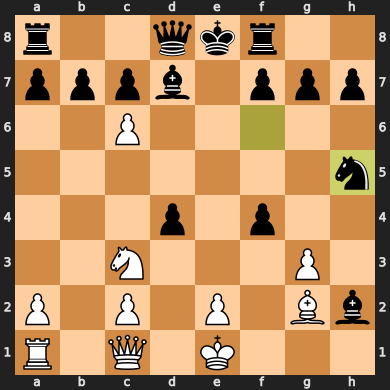

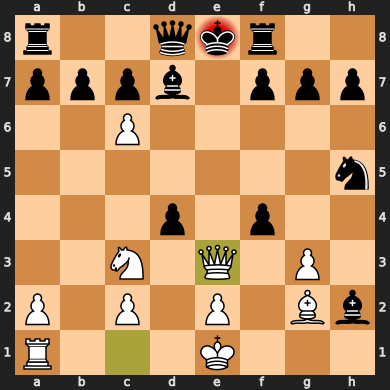

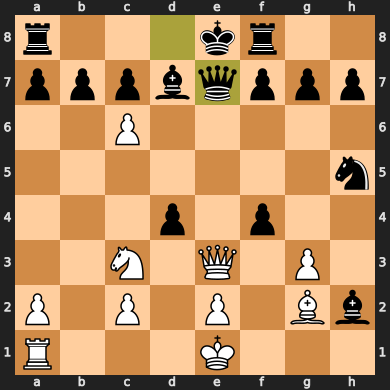

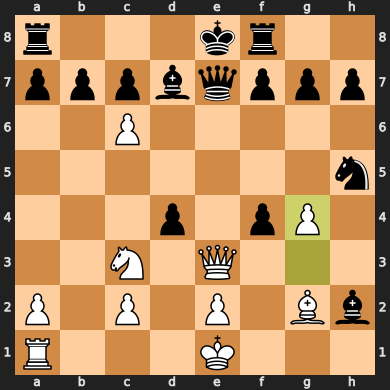

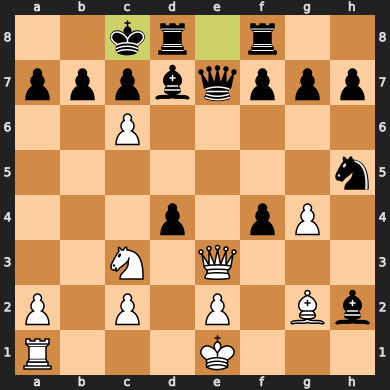

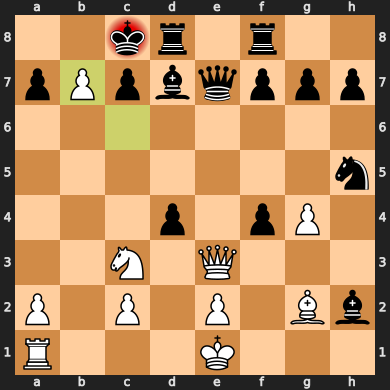

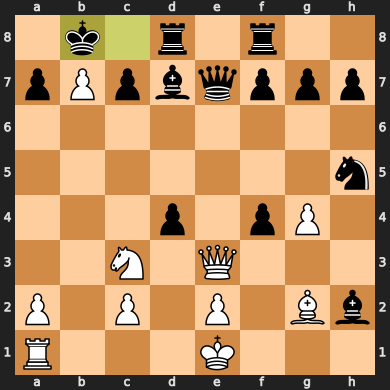

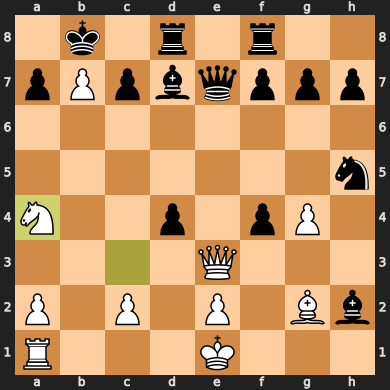

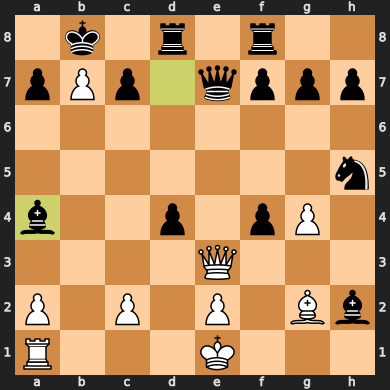

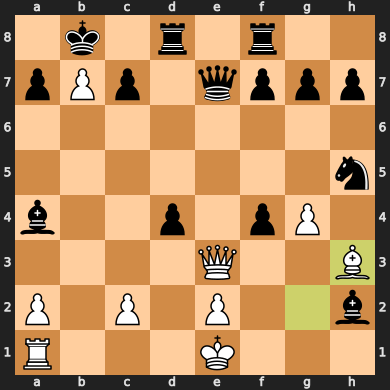

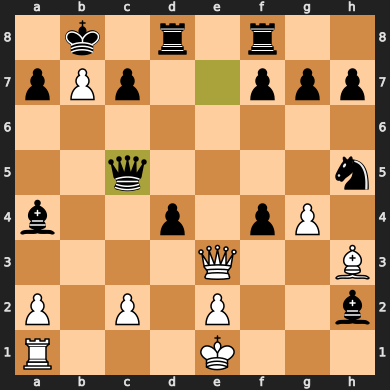

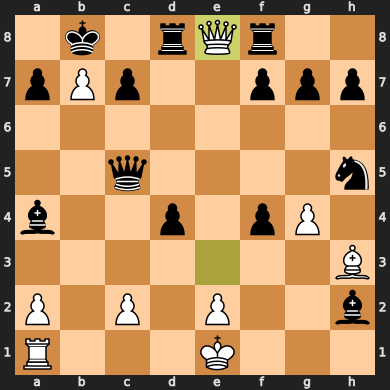

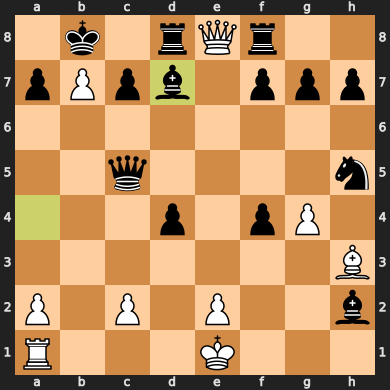

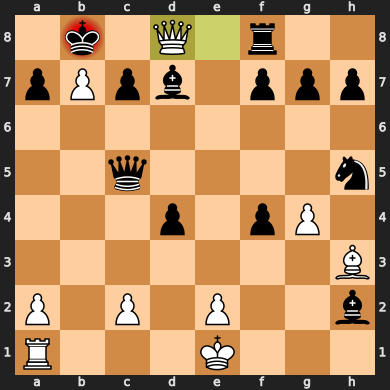

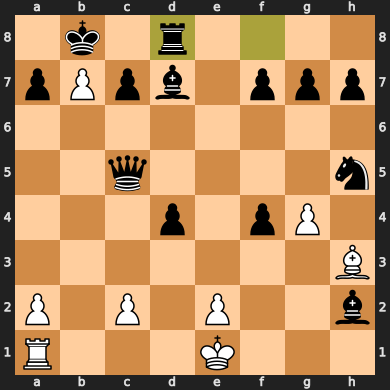

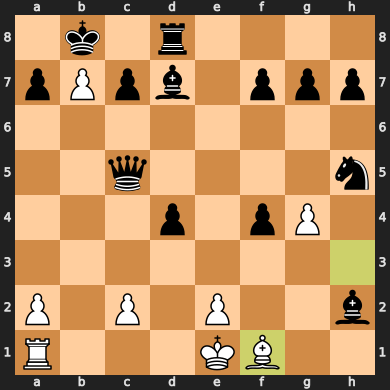

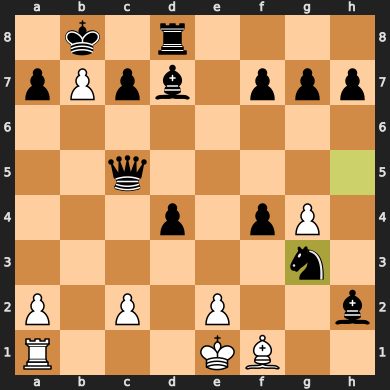

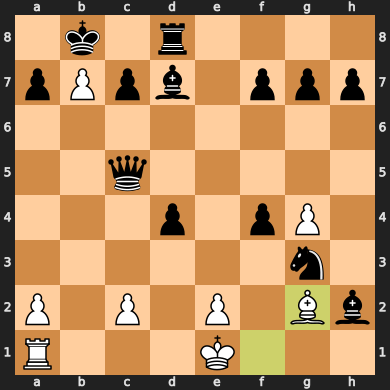

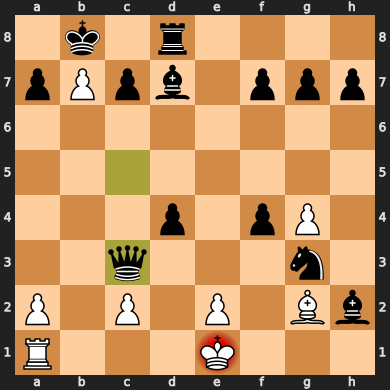

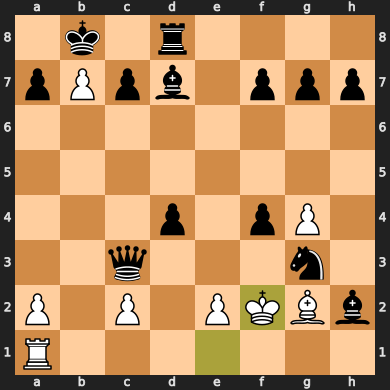

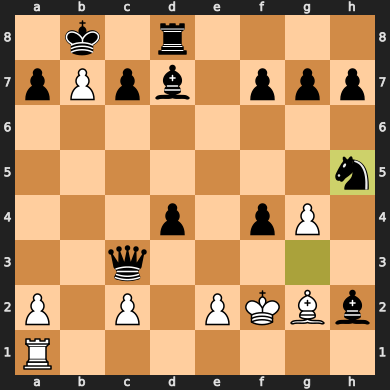

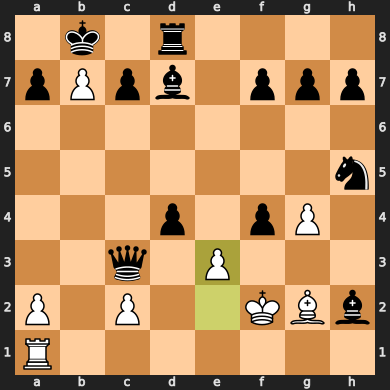

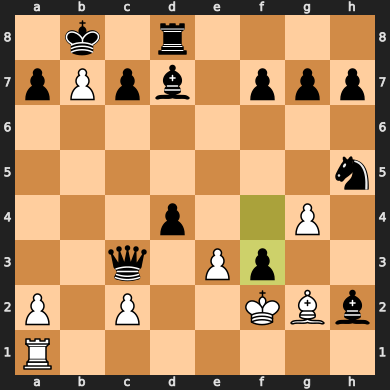

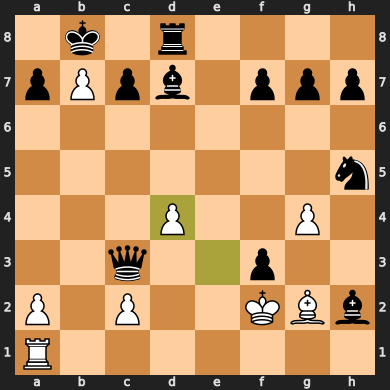

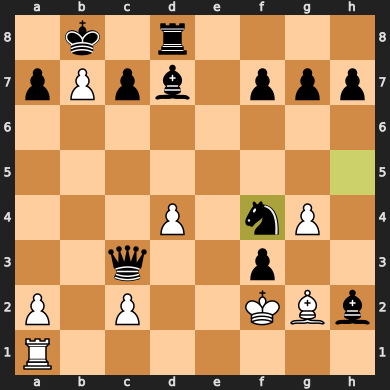

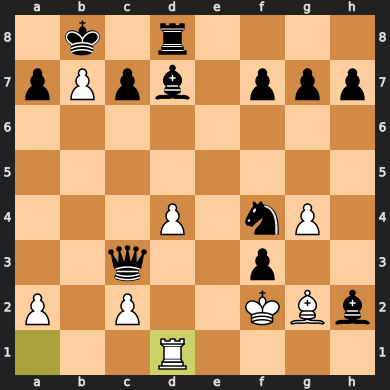

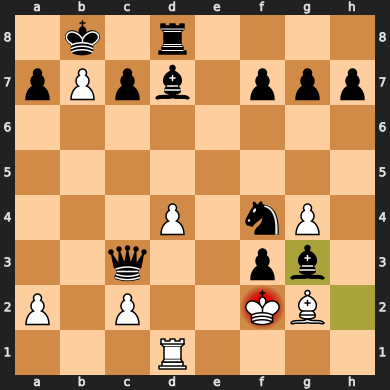

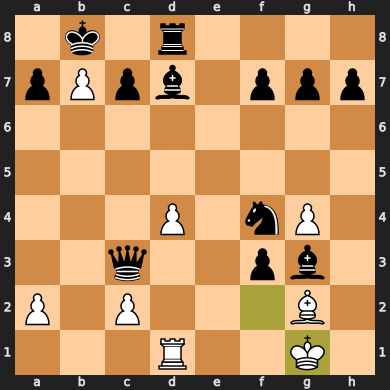

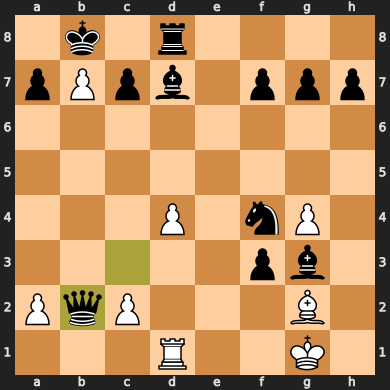

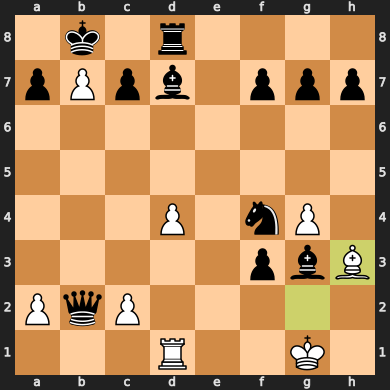

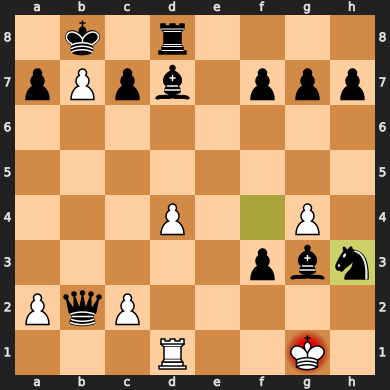

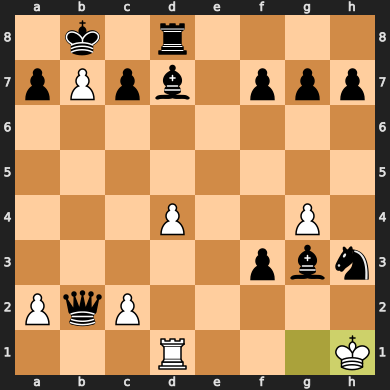

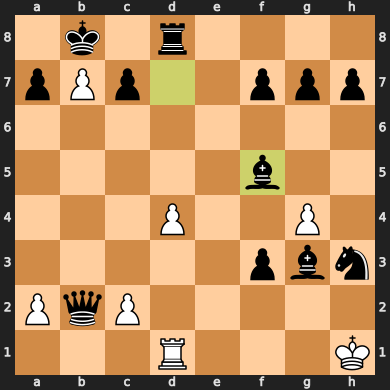

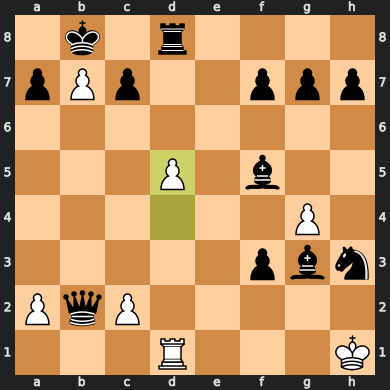

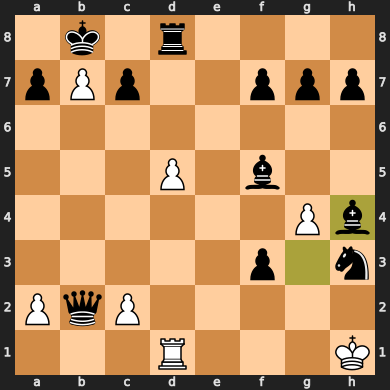

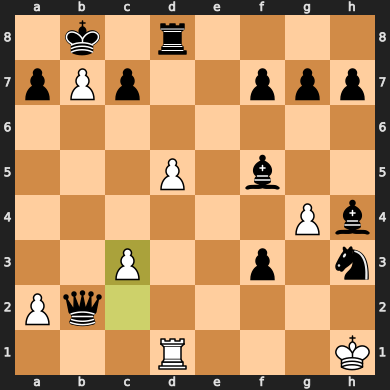

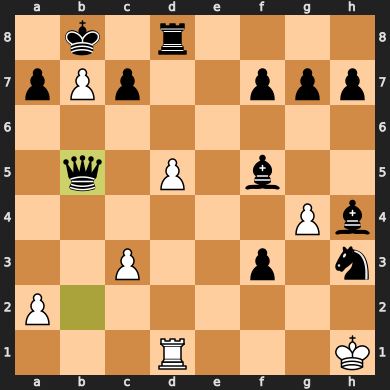

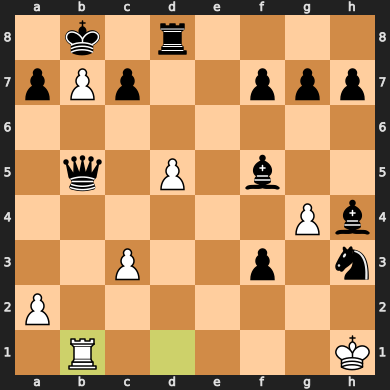

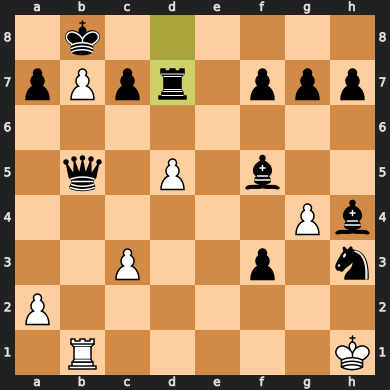

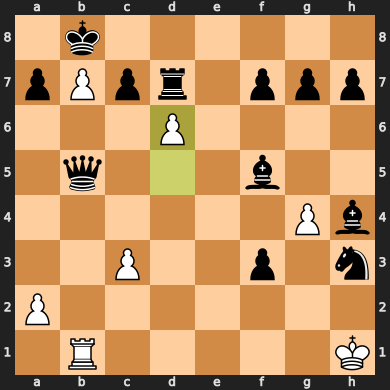

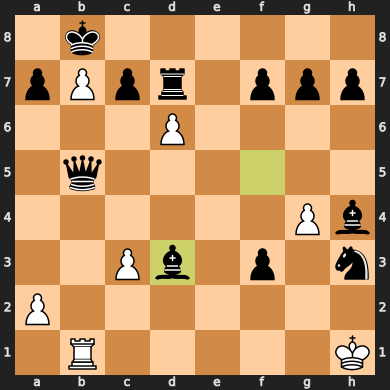

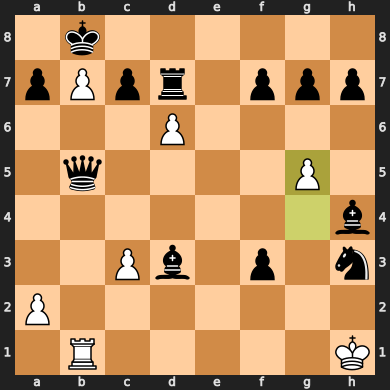

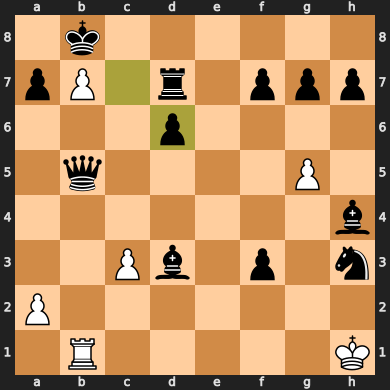

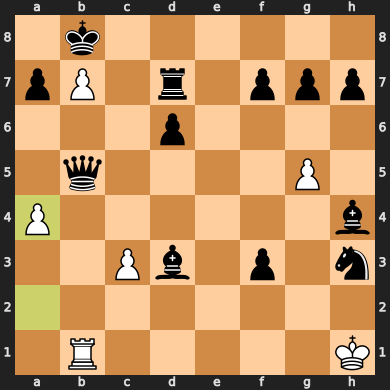

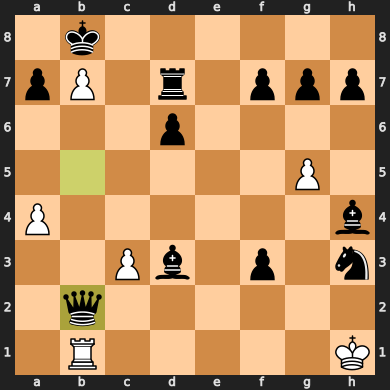

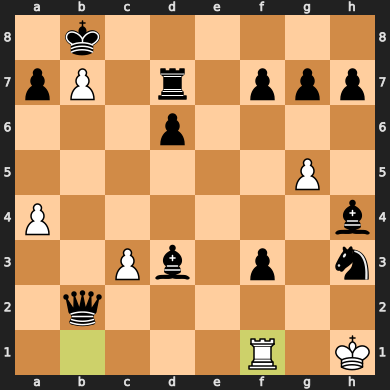

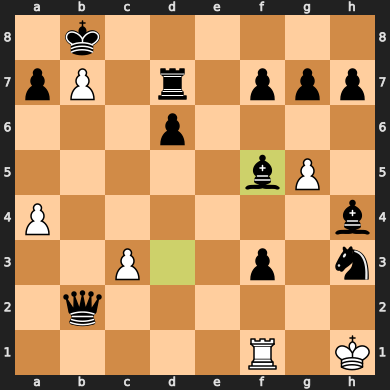

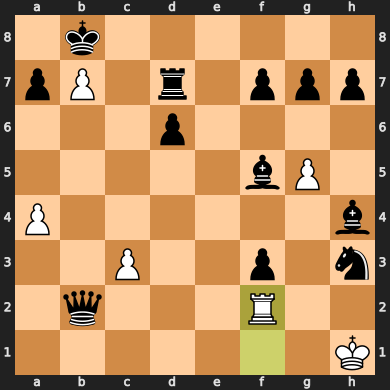

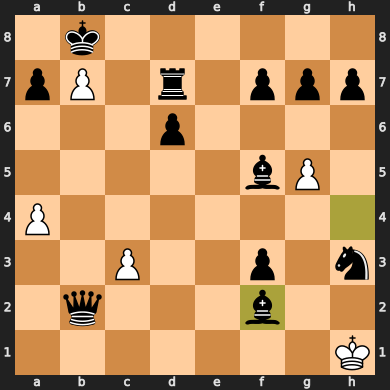

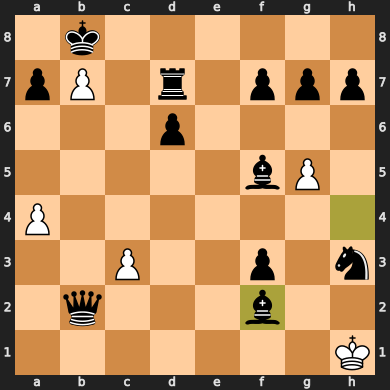

In [54]:
play_game(random_agent, model_agent, verbose=True)